In [171]:
#Estaremos utilizando las bibliotecas de la actividad anterior
import pandas as pd              
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Estas bibliotecas son para el análisis de series de tiempo y pronósticos
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

In [172]:
#En resumen de la actividad anterior tenemos
url1 = "https://raw.githubusercontent.com/HumbertoMezaRuiz/FisicaComputacional1/main/Actividad5/26329.txt"#Definimos este link para usar el texo desde ahi

encabezado = ['Fecha','Precipit','Evap','Tmax','Tmin']#Definimos aqui los encabezados para tener mas orden al definir el df

#Ahora definimos nuestro df, donde como archivo pondremos el link url1 y en names, los encabezado definidos previamente
df_dist = pd.read_csv(url1, names=encabezado, encoding='cp1251', sep='\s+', skiprows=19, skipfooter=2, header=None, engine='python')

df_work0 = df_dist.copy()     #Hacemos una copia de nuestros datos para manipularlos sin miedo a perderlos

str_Nulo = 'Nulo'    #Aqui pondremos lo que querramos quitar, es decir, en mis datos hay datos que dicen 'nulos'

df_work1 = df_work0.replace(to_replace=str_Nulo, value='', regex=True)        #Reemplazamos todos los nulos, en este caso, quedara en blanco

# Deseamos convertir los valores de las variables ambientales a núm. flotantes 
cols_list = ['Precipit', 'Evap', 'Tmax', 'Tmin']
for cols in cols_list:
  df_work1[cols] = pd.to_numeric(df_work1[cols], errors='coerce')

df_work2 = df_work1.copy() #hacemos otra copia para hacer otro cambio

df_work2['Fecha']=pd.to_datetime(df_work2['Fecha'], dayfirst=True).copy() #Le decimos a python que esa columna son fehcas y le decimos que el primer numero son los dias

df_work2['Año'] = df_work2['Fecha'].dt.year  #Vamos a crear una columna con el año de las fechas

df_work2['Mes'] = df_work2['Fecha'].dt.month #y otras con el mes
 
############################################################################################################################################
df_meteo = df_work2.copy()# Definimos un nuevo DataFrame para el análisis de los datos meteorológicos.
df_meteo.info()
#print(df_meteo.head())
#print(df_meteo.tail())

df_meteo_ts = df_meteo.copy() # Hacemos una copia para darle sin miedo

df_meteo_ts = df_meteo_ts.set_index('Fecha') # Con esto hacemos que en vez de enumerar las filas, sale directamente por fecha

df_meteo_ts.info()

# Vamos a utilizar los últimos 30 años de datos, que corresponden al periodo 1986-2016
df_30años = df_meteo_ts[(df_meteo_ts['Año'] >= 1990) & (df_meteo_ts['Año'] < 2017)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Fecha     10716 non-null  datetime64[ns]
 1   Precipit  10715 non-null  float64       
 2   Evap      1706 non-null   float64       
 3   Tmax      10624 non-null  float64       
 4   Tmin      10626 non-null  float64       
 5   Año       10716 non-null  int64         
 6   Mes       10716 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 586.2 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10716 entries, 1984-01-01 to 2016-03-30
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Precipit  10715 non-null  float64
 1   Evap      1706 non-null   float64
 2   Tmax      10624 non-null  float64
 3   Tmin      10626 non-null  float64
 4   Año       10716 non-null  int64  
 5   Mes 

In [173]:
# Función para probar la estacionaridad de una serie de tiempo: 'timeseries'
   
def test_stationarity(df_ts):
    
    #Determinar la Estadística de promedios móviles
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 
    
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística de promedios móviles 
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Promedio móvil')
    plt.plot(rolstd, color='black', label = 'Desviación estándar móvil')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de  Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Estadístico','valor P','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Valor Crítico (%s)'%key] = value
    print(dfoutput)

**Actividad 1.** Tomar una serie de datos en un periodo sin huecos (Tmax, Tmin) de la estación que se está analizando, para probar si es una serie de tiempo estacionaria o hacer las transformaciones para convertirla en una. Ver el ejemplo mostrado en la Jupyter Notebook de esta actividad para realizar las acciones similares. 

In [174]:
# Creamos la primer serie de Tiempo para analizar, 
# haciendo una copia de la epoca de 1990 a 2017 
# o el periodo que se desee. Podemos regresar a esta punto las veces que se requiera definir

# Fechas de inicio y fin, para filtrar la información
start, end = '1997-01', '2001-01'

Periodo_prueba = df_30años.loc[start:end].copy()
Periodo_prueba.head()

,Precipit,Evap,Tmax,Tmin,Año,Mes
Fecha,,,,,,
1997-01-01,0.0,NaN,33.0,5.0,1997,1
1997-01-02,0.0,NaN,33.0,7.0,1997,1
1997-01-03,0.0,NaN,32.0,12.0,1997,1
1997-01-04,0.0,NaN,32.0,11.0,1997,1
1997-01-05,0.0,NaN,26.0,10.0,1997,1


In [175]:
# Vemos su encabezado
Periodo_prueba['Tmax'].head()

Fecha
1997-01-01    33.0
1997-01-02    33.0
1997-01-03    32.0
1997-01-04    32.0
1997-01-05    26.0
Name: Tmax, dtype: float64

In [176]:
# Definimos la Serie de Tiempo con Tmax que vamos a estudiar

Periodo_prueba = ts_30años['Tmax'].copy()

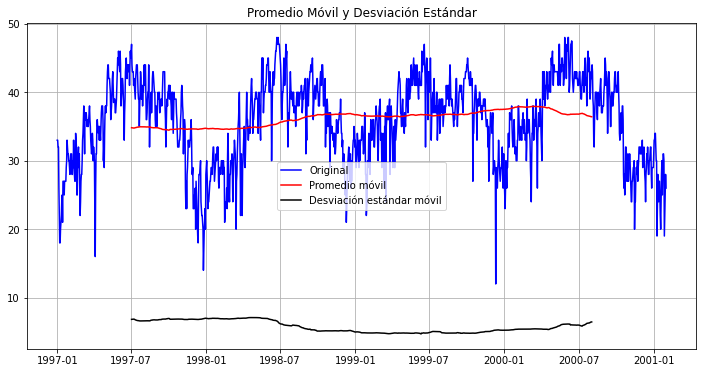

Resultados de la Prueba de Dickey-Fuller:
Test Estadístico                 -2.830708
valor P                           0.054020
#Lags Used                       16.000000
Number of Observations Used    1475.000000
Valor Crítico (1%)               -3.434791
Valor Crítico (5%)               -2.863501
Valor Crítico (10%)              -2.567814
dtype: float64


In [177]:
# Realizamos la Prueba de Estacionaridad de Tmax
test_stationarity(Periodo_prueba)

En este caso la serie no obtuvo un valor P adecuado, notamos que la tendencia y estacionalidad hacen que no sea rentable, por lo que haremos lo siguiente


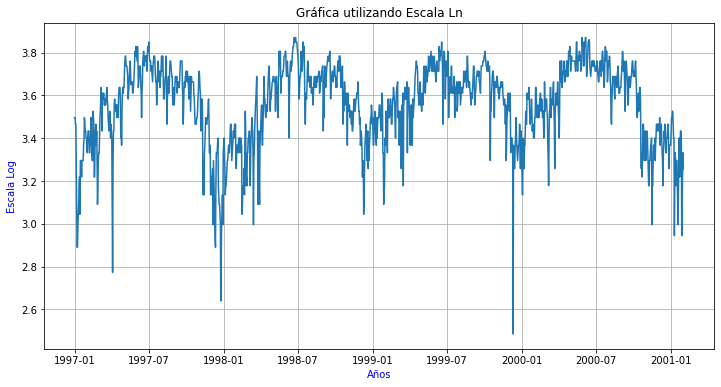

In [178]:
# Seleccionamos la función logaritmo (base 10) y graficamos
Periodo_prueba_ln = np.log(Periodo_prueba)
plt.plot(Periodo_prueba_ln)
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Ln')
plt.grid()
plt.show();

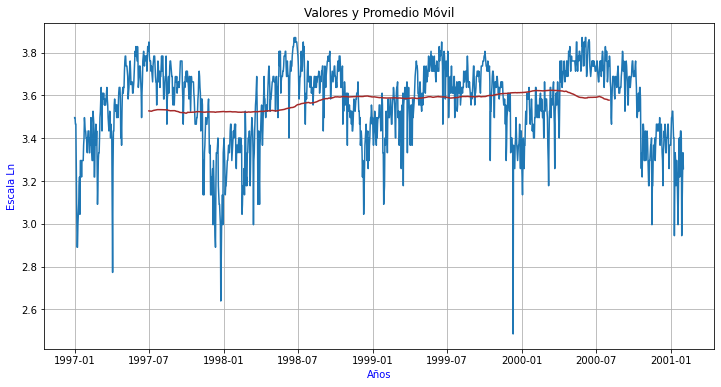

In [179]:
## Vamos a graficar el promedio móvil de 365 días para ver si se mejoró un poco la tendencia para que sea constante
Promedio_movil = Periodo_prueba_ln.rolling(365, center=True).mean()
plt.plot(Periodo_prueba_ln)
plt.plot(Promedio_movil, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Ln',color='b')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show();

A primera vista ya se nota que no será suficiente el cambio de escala, pues la tendencia aún es bastante variable (cuando necesitamos que sea lo más constante posible)

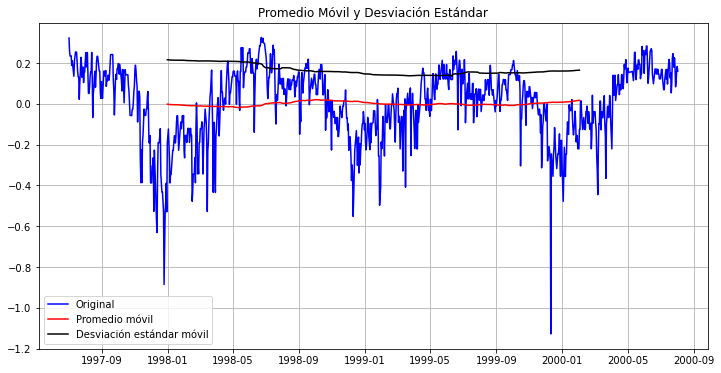

Resultados de la Prueba de Dickey-Fuller:
Test Estadístico                 -2.513939
valor P                           0.112120
#Lags Used                       16.000000
Number of Observations Used    1111.000000
Valor Crítico (1%)               -3.436250
Valor Crítico (5%)               -2.864145
Valor Crítico (10%)              -2.568157
dtype: float64


In [180]:
Periodo_prueba_ln_moving_ave_diff = Periodo_prueba_ln - Promedio_movil  ## Movemos a una altura 0

Periodo_prueba_ln_moving_ave_diff.dropna(inplace=True)
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log
test_stationarity(Periodo_prueba_ln_moving_ave_diff)

Como predijimos, aún así no tenemos una serie estacionaria. Cambiemos el tipo de promedio móvil, pasando a un promedio móvil exponencial como sigue

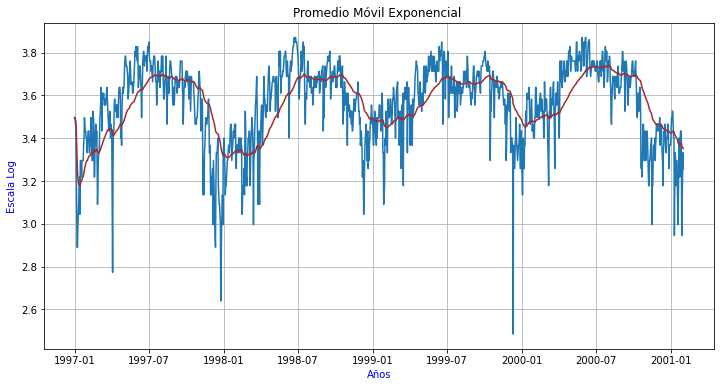

In [181]:
# Repetimos el cálculo usando promedios móviles exponenciales, 
# el parámetro 'halflife' representa el número de días que tienen cierta influencia
# en el promedio, pero su influencia decae exponencialmente.  

EWM_avg = Periodo_prueba_ln.ewm(halflife=30).mean() # Usando 30 días como vida media
plt.plot(Periodo_prueba_ln)
plt.plot(EWM_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Promedio Móvil Exponencial ')
plt.grid()
plt.show();

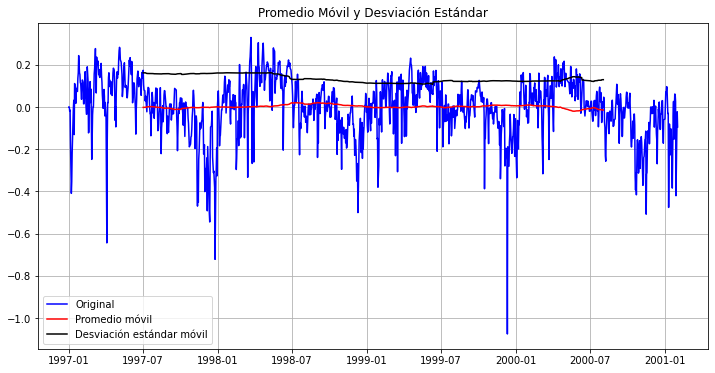

Resultados de la Prueba de Dickey-Fuller:
Test Estadístico                 -4.134830
valor P                           0.000848
#Lags Used                       16.000000
Number of Observations Used    1475.000000
Valor Crítico (1%)               -3.434791
Valor Crítico (5%)               -2.863501
Valor Crítico (10%)              -2.567814
dtype: float64


In [182]:
# Probamos la estacionarida de la diferencia 
Periodo_prueba_ln_EWM_avg_diff = Periodo_prueba_ln - EWM_avg
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log y usando EWM
test_stationarity(Periodo_prueba_ln_EWM_avg_diff)

Nuestro valor P ya es bastante bueno, ya que es menor al 5%, por mucho, confiaremos en este formato de los datos para continuar la actividad.

Ahora checamos la estacionalidad, esto es, las variaciones de la temperatura por causa de las estaciones del año. Lo haremos por el método de la **descomposición**, para ello están las bibliotecas *statsmodels.tsa*

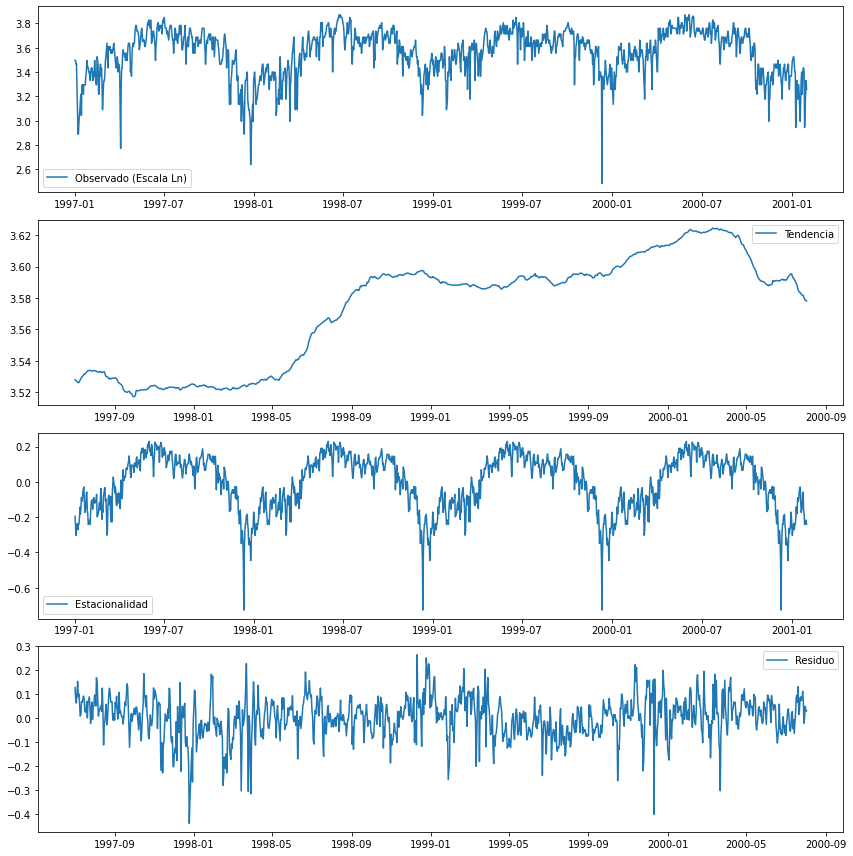

In [183]:
# Método de descomposición usando la biblioteca statsmodels.tsa

decomposicion = sm.tsa.seasonal_decompose(Periodo_prueba_ln.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

Tendencia = decomposicion.trend
Estacionalidad = decomposicion.seasonal
residuo = decomposicion.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(Periodo_prueba_ln, label='Observado (Escala Ln)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(Tendencia, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(Estacionalidad, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residuo, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

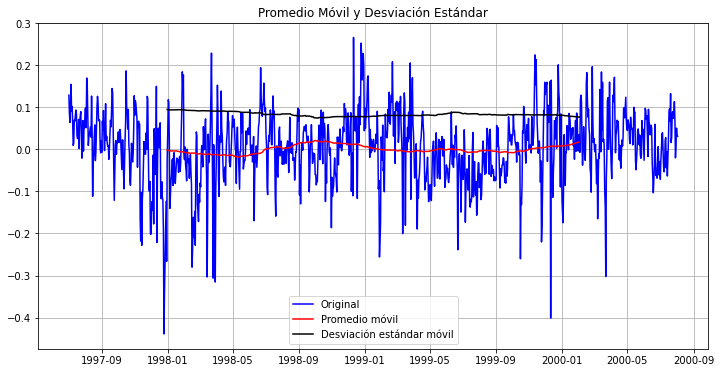

Resultados de la Prueba de Dickey-Fuller:
Test Estadístico              -5.830458e+00
valor P                        3.986441e-07
#Lags Used                     1.400000e+01
Number of Observations Used    1.113000e+03
Valor Crítico (1%)            -3.436239e+00
Valor Crítico (5%)            -2.864140e+00
Valor Crítico (10%)           -2.568154e+00
dtype: float64


In [184]:
# Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria o no...

Periodo_prueba_decompose = residuo
Periodo_prueba_decompose.dropna(inplace=True)
test_stationarity(Periodo_prueba_decompose)

El valor P es más que confiable pues es demasiado pequeño, por lo que podemos proseguir confiando en que se trata de una serie es estacionaria.

**No me fue posible realizar el procedimiento para la temperatura mínima, pues no encontré un intervalo para el cual funcionara la función test_stationarity**

**Actividad 2.** Construye los modelos ARIMA para cada Temperatura (Tmax y Tmin), y contrasta la bondad del ajuste en cada caso, calculando el error de la raíz cuadrada promedio RMSE y sobreponiendo gráficamente ambas series, la observada y la construida con el método ARIMA.

 

Vamos a utilizar el método ARIMA. Para esto requerimos dos valores *q* y *p*, los cuales obtenemos como sigue

In [193]:
# Diferenciamos usando la función df.shift()
Periodo_prueba_ln_diff = Periodo_prueba_ln - Periodo_prueba_ln.shift(periods=7)
Periodo_prueba_ln_diff.dropna(inplace=True)

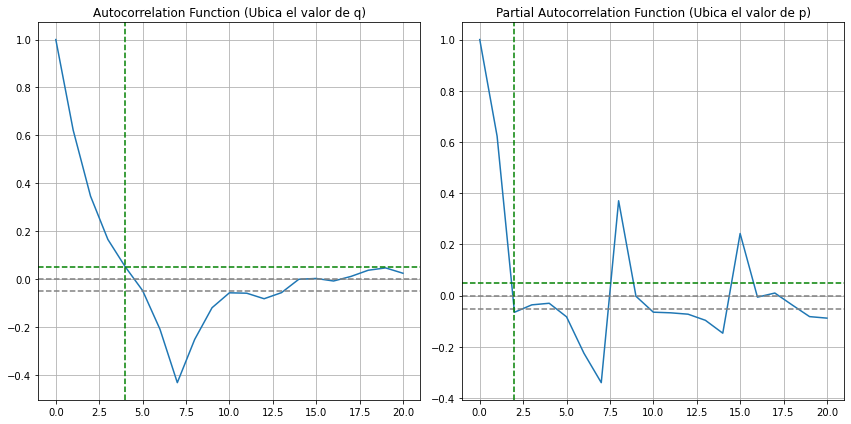

In [192]:
lag_acf = acf(Periodo_prueba_ln_diff, nlags=20)
lag_pacf = pacf(Periodo_prueba_ln_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Periodo_prueba_ln_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(Periodo_prueba_ln_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Periodo_prueba_ln_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(Periodo_prueba_ln_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

Gracias a la primera gráfica podemos tomar q=4.

Y gracias a la segunda, podemos tomar p=2

A partir de aquí, podemos comenzar a construir los modelos ARIMA.

# **MODELO AR** (auto regresión)
En este modelo, tomares únicamente el valor p, haremos que q sea igual a cero.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 1491
Model:                 ARIMA(2, 1, 0)   Log Likelihood                2772.347
Method:                       css-mle   S.D. of innovations              0.038
Date:                Sun, 21 Feb 2021   AIC                          -5536.695
Time:                        10:06:00   BIC                          -5515.466
Sample:                    01-02-1997   HQIC                         -5528.784
                         - 01-31-2001                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -6.704e-05      0.001     -0.090      0.928      -0.002       0.001
ar.L1.D.Tmax    -0.1642      0.026     -6.408      0.000      -0.214      -0.114
ar.L2.D.Tmax    -0.1437      0.026     -5.60

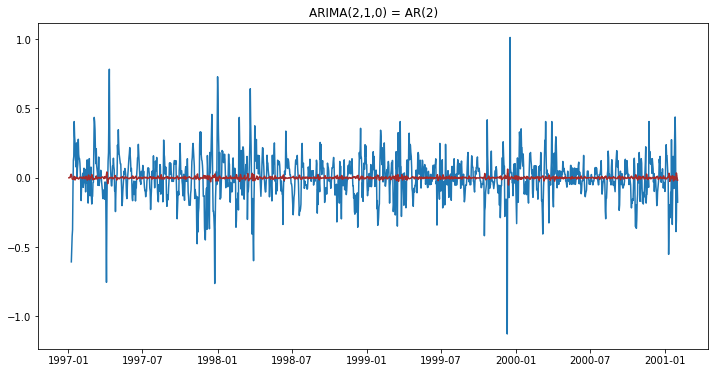

In [195]:
model = ARIMA(ts_test_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(Periodo_prueba_ln_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

# **MODELO MA** (promedio móvil)
En este modelo, tomares únicamente el valor q, haremos que p sea igual a cero.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 1491
Model:                 ARIMA(0, 1, 4)   Log Likelihood                1589.451
Method:                       css-mle   S.D. of innovations              0.083
Date:                Sun, 21 Feb 2021   AIC                          -3166.901
Time:                        10:09:05   BIC                          -3135.058
Sample:                    01-02-1997   HQIC                         -3155.035
                         - 01-31-2001                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -3.765e-05      0.001     -0.064      0.949      -0.001       0.001
ma.L1.D.Tmax    -0.2559      0.026     -9.937      0.000      -0.306      -0.205
ma.L2.D.Tmax    -0.1994      0.026     -7.62

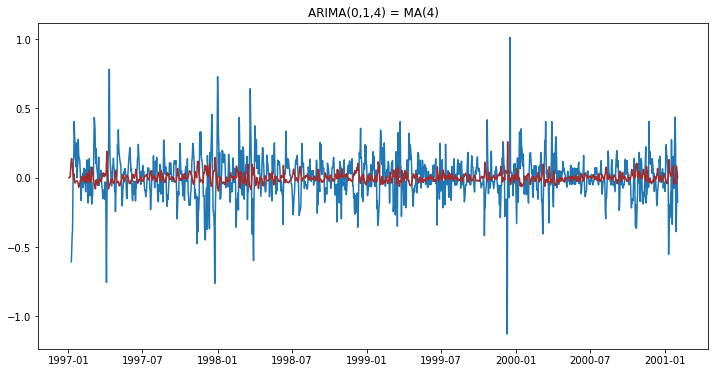

In [197]:
# Modelo MA(q): (p,d,q) = (0,1,4) 
model = ARIMA(Periodo_prueba_ln, order=(0,1,4), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(Periodo_prueba_ln_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())

# **MODELO ARIMA** (auto regresión + promedio móvil)
p=2, q=4

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 1491
Model:                 ARIMA(2, 1, 4)   Log Likelihood                1590.749
Method:                       css-mle   S.D. of innovations              0.083
Date:                Sun, 21 Feb 2021   AIC                          -3165.499
Time:                        10:10:35   BIC                          -3123.041
Sample:                    01-02-1997   HQIC                         -3149.677
                         - 01-31-2001                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.929e-05      0.001     -0.047      0.962      -0.001       0.001
ar.L1.D.Tmax     1.4760      0.116     12.675      0.000       1.248       1.704
ar.L2.D.Tmax    -0.5175      0.100     -5.17

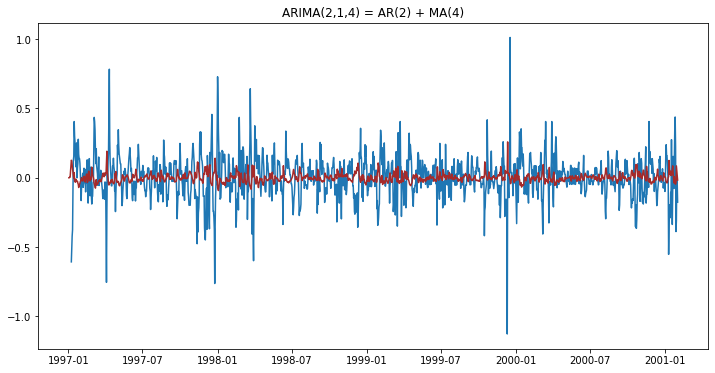

In [198]:
model = ARIMA(Periodo_prueba_ln, order=(2,1,4), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(Periodo_prueba_ln_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())

El Criterio de Información de Akaike (AIC), como indicador del mejor modelo ARIMA.

El criterio AIC se basa en dos principios:

Bondad del ajuste
Simplicidad del modelo o principio de parsimonia.
Aquel modelo que tenga el menor AIC, y los valores más pequeños de (p,d,q) se selecciona como el mejor modelo de ajuste.

Cuando imprimimos los resúmenes de los modelos con la función results.summary(), nos regresa una serie de valores y parámetros.

Entre ellos se encuentra el criterio AIC.

ARIMA(2,1,0): AIC = -5536.695 <- Es el menor AIC

ARIMA(0,1,4): AIC = -3166.901

ARIMA(2,1,4): AIC = -3165.499 

Podemos afirmar que ARIMA(2,1,0) es el mejor modelo de los 3 que exploramos.

Ahora podemos continuar utilizando el modelo que se consideró mejor

In [199]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA(2,1,0)
predicciones_AR_diff = pd.Series(results_AR.fittedvalues, copy=True)
print(predicciones_AR_diff)

Fecha
1997-01-02   -0.000067
1997-01-03   -0.000077
1997-01-04    0.002107
1997-01-05    0.001833
1997-01-06    0.014719
                ...   
2001-01-27    0.002251
2001-01-28    0.034531
2001-01-29    0.017969
2001-01-30   -0.018355
2001-01-31   -0.016149
Length: 1491, dtype: float64


In [200]:
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predicciones_AR_ln = pd.Series(Periodo_prueba_ln, index = Periodo_prueba_ln.index)
predicciones_AR_ln = predicciones_AR_ln.add(predicciones_AR_diff)
print(predicciones_AR_ln.head())
print(predicciones_AR_ln.tail())

Fecha
1997-01-01         NaN
1997-01-02    3.496441
1997-01-03    3.465659
1997-01-04    3.467843
1997-01-05    3.259930
dtype: float64
Fecha
2001-01-27    2.946690
2001-01-28    3.125574
2001-01-29    3.236845
2001-01-30    3.313850
2001-01-31    3.241948
dtype: float64


Lo siguiente es contrastar ambas gráficas, la original, y las predicciones

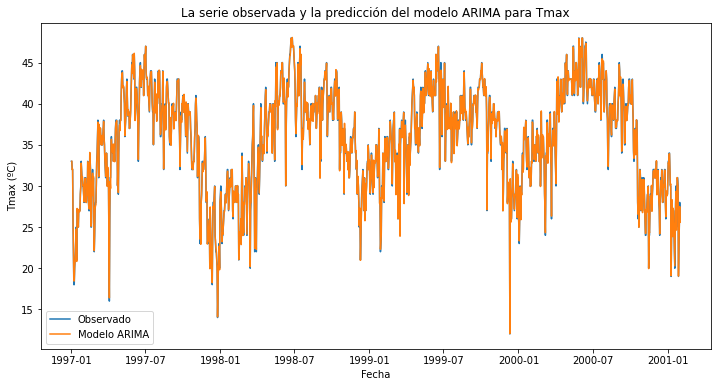

In [205]:
# Regresamos a la escala de Temperatura original, para eliminar el logaritmo usamos @ e**log @
predicciones_AR = np.e**(predicciones_AR_ln)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(Periodo_prueba, label='Observado');
plt.plot(predicciones_AR, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmax')
plt.legend(loc='best');

Como vemos, las predicciones son bastantes buenas. Vamos a calcular el error RMSE (error de la raíz cuadrada de la media)

In [207]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((predicciones_AR - Periodo_prueba)**2))
print('RMSE:', RMSE)

RMSE: 0.24868598718540774


Para apreciar un poco más de cerca las diferencias de valores en la gráfica veamos un corto periodo graficando únicamente los dos últimos años de la gráfica anterior

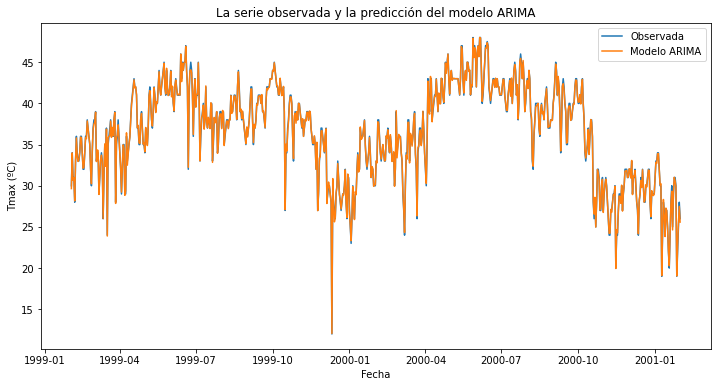

In [208]:
# Graficamos sólo los útimos datos de las series 
Periodo_prueba_final = Periodo_prueba.tail(730)
predicciones_AR_final = predicciones_AR.tail(730)
plt.plot(Periodo_prueba_final, label='Observada');
plt.plot(predicciones_AR_final, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');

Bastante satisfactorio el resultado la verdad.